In [3]:
from spacy.lang.en import English
import spacy
spacy.prefer_gpu()
from collections import Counter
import csv
import config
import tensorflow as tf
import numpy as np
import pandas as pd
import random as rnd
import subprocess
import os
import nltk
from nltk.corpus import stopwords
import re
import string
from collections import OrderedDict, defaultdict
from sklearn.linear_model import LogisticRegression
import fnmatch
#from tensorflow.keras.preprocessing.text import Tokenizer
from src.CustomTokenizer import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
import json
from tqdm import tqdm
from data_processing.preprocessing import get_dataset_text, get_word_index_list, write_index_to_file, read_index_as_string

## Load Training set

In [4]:
train_dataset = config.config_io.get('pan_20_processed_train_narrow')
test_dataset = config.config_io.get('pan_20_processed_test_narrow')

In [6]:

print("Loading training file from path: ", train_dataset)
training_data = pd.read_csv(train_dataset)
training_data.shape

Loading training file from path:  /home/sukanya/PhD/Datasets/PAN SCD/pan20-style-change-detection/processed/train/narrow.csv


(83012, 5)

In [7]:
training_data.head()

,problem,author_1,author_2,para1_text,para2_text
0,problem-1543.txt,A1,A1,Full info of components of Linux Traffic Contr...,The first word in the DNS entry clearly says i...
1,problem-1543.txt,A1,A1,The first word in the DNS entry clearly says i...,I think you can see the point. If you are not ...
2,problem-1543.txt,A1,A1,I think you can see the point. If you are not ...,You should edit your expect script to allow fo...
3,problem-1543.txt,A1,A1,You should edit your expect script to allow fo...,You could either have a firewall rule blocking...
4,problem-1543.txt,A1,A2,You could either have a firewall rule blocking...,"You asked for ""up to date"", so something from ..."


In [8]:
training_data.columns

Index(['problem', 'author_1', 'author_2', 'para1_text', 'para2_text'], dtype='object')

## Load Testing set

In [9]:
print("Loading testing file from path: ", test_dataset)
testing_data = pd.read_csv(test_dataset)
testing_data.shape

Loading testing file from path:  /home/sukanya/PhD/Datasets/PAN SCD/pan20-style-change-detection/processed/test/narrow.csv


(41749, 5)

In [10]:
testing_data.head()

,problem,author_1,author_2,para1_text,para2_text
0,problem-1543.txt,A1,A1,For your particular problem I'm not sure that ...,Perform dimensionality reduction (such as LSA ...
1,problem-1543.txt,A1,A2,Perform dimensionality reduction (such as LSA ...,"I read all answers, I think the simplest answe..."
2,problem-1543.txt,A2,A2,"I read all answers, I think the simplest answe...",Best by cross validation The whole data can be...
3,problem-1543.txt,A2,A2,Best by cross validation The whole data can be...,I have an answer now for my question. I will s...
4,problem-1543.txt,A2,A3,I have an answer now for my question. I will s...,Imagine that the hyperparameter is a L2 penalt...


## Load the feature set files
We are doing it manually now for greater control. In the future, we must automate to read the files directly form the directory.

In [11]:
# index files

feature_set_files = { 'opt1':
['/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/50word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/100word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/150word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/200word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/250word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/300word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/350word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/400word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/450word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/500word_list.txt'],
                    'opt2':
['/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt2/50word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt2/100word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt2/150word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt2/200word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt2/250word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt2/300word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt2/350word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt2/400word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt2/450word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt2/500word_list.txt'],
                    'opt3':
['/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt3/50word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt3/100word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt3/150word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt3/200word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt3/250word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt3/300word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt3/350word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt3/400word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt3/450word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt3/500word_list.txt'],
                    'opt4':
['/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt4/50word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt4/100word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt4/150word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt4/200word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt4/250word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt4/300word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt4/350word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt4/400word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt4/450word_list.txt',
'/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt4/500word_list.txt']}


In [12]:
#nlp = English()
nlp = spacy.load("en_core_web_sm")

In [13]:
nlp.pipeline

[('tagger', <spacy.pipeline.pipes.Tagger at 0x7f77ecf39fa0>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x7f77ed592160>),
 ('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x7f77ed3d5e80>)]

In [14]:
# takes micro seconds 90.7 µs ± 962 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each), 100 times faster than below loop
def custom_analyzer(text):
    #doc = nlp(text.lower())
    doc = list(nlp.pipe([text.lower()], disable=["tagger", "parser","ner"]))[0]
    return [t.text for t in doc]

print(custom_analyzer("A very large line this is I don't know how this works yet! God Save me!!"))

['a', 'very', 'large', 'line', 'this', 'is', 'i', 'do', "n't", 'know', 'how', 'this', 'works', 'yet', '!', 'god', 'save', 'me', '!', '!']


In [15]:
# takes mili seconds 4.23 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
'''def custom_analyzer(text):
    doc = nlp(text.lower())
    #doc = list(nlp.pipe([text.lower()], disable=["tagger", "parser","ner"]))[0]
    return [t.text for t in doc]

print(custom_analyzer("A very large line this is I don't know how this works yet! God Save me!!"))'''

'def custom_analyzer(text):\n    doc = nlp(text.lower())\n    #doc = list(nlp.pipe([text.lower()], disable=["tagger", "parser","ner"]))[0]\n    return [t.text for t in doc]\n\nprint(custom_analyzer("A very large line this is I don\'t know how this works yet! God Save me!!"))'

In [16]:
feature_set_files

{'opt1': ['/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/50word_list.txt',
  '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/100word_list.txt',
  '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/150word_list.txt',
  '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/200word_list.txt',
  '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/250word_list.txt',
  '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/300word_list.txt',
  '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/350word_list.txt',
  '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/400word_list.txt',
  '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/450word_list.txt',
  '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/500word_list.txt'],
 'opt2': ['/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt2/50word_list.txt',
  '/home/sukanya/PycharmProjects/SiameseNNPAN/src/

In [17]:
metrics = {}
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

for key in list(feature_set_files.keys()):
    print(key)
    temp_metrics_dict={}
    vocab_files = []
    training_acc = []
    training_loss = []
    validation_loss = []
    validation_acc = []
    testing_acc= []
    testing_loss = []
    vocab_size_list = []
    print(key, feature_set_files.get(key))
    for feature_file in feature_set_files.get(key):
        word_tokenizer = Tokenizer(analyzer=custom_analyzer)
        with open(feature_file, "r") as f:
            word_index_str = f.read().replace('\n', '')
        print(word_index_str)
        word_tokenizer.fit_on_texts([word_index_str])
        len_train = len(training_data)
        # define the generators
        from src.DataGenerator import DataGenerator
        training_generator = DataGenerator(training_data.iloc[0:int(0.8*len_train)], tokenizer=word_tokenizer, batch_size=16)
        validation_generator = DataGenerator(training_data.iloc[int(0.8*len_train):], tokenizer=word_tokenizer, batch_size=16)
        testing_generator = DataGenerator(testing_data, tokenizer=word_tokenizer, batch_size=16)

        # this is a hack for "'DataGenerator' object has no attribute 'index'". It turns out that on_epoch_end creates the index that is used
        training_generator.on_epoch_end()
        validation_generator.on_epoch_end()
        testing_generator.on_epoch_end()
        # parameters
        num_classes =2
        num_features = 1

        # define model
        model = Sequential()
        model.add(Dense(50, input_dim=num_features, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(num_classes, activation='softmax'))

        # compile model
        opt = SGD(lr=0.01, momentum=0.9)
        #model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        # fit model
        history = model.fit(training_generator, validation_data=validation_generator, verbose=1, batch_size=16, 
                             epochs=30, steps_per_epoch=100, callbacks=[callback]) #validation_steps=100,

        history_dict = history.history
        vocab_files.append(feature_file.split('/')[-1])
        json.dump(history_dict, open("history_" + key + "_" +feature_file.split('/')[-1], 'w'))
        loss = history_dict['loss'][-1]
        training_loss.append(loss)
        acc = history_dict['accuracy'][-1]
        training_acc.append(acc)
        val_loss = history_dict['val_loss'][-1]
        validation_loss.append(val_loss)
        val_acc = history_dict['val_accuracy'][-1]
        validation_acc.append(val_acc)
        test_loss, test_acc = model.evaluate(testing_generator)
        testing_acc.append(test_acc)
        testing_loss.append(test_loss)
        vocab_size_list.append(feature_file.split('/')[-1])
        print("training acc: ", acc, ", training loss: ", loss, ", val acc: ", val_acc, ", val loss: ", val_loss,", test acc: ", test_acc, ", test loss: ", test_loss)
        print()
    temp_metrics_dict={'Feature Set Size':vocab_size_list,
         'Training Accuracy': training_acc,
         'Validation Accuracy': validation_acc, 
         'Testing Accuracy':testing_acc,
         'Training Loss' : training_loss,
         'Validation Loss': validation_loss,
         'Testing Loss':testing_loss}
    json.dump(temp_metrics_dict, open("total_history_" + key, 'w'))
    metrics[key] = temp_metrics_dict
    

opt1
opt1 ['/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/50word_list.txt', '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/100word_list.txt', '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/150word_list.txt', '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/200word_list.txt', '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/250word_list.txt', '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/300word_list.txt', '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/350word_list.txt', '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/400word_list.txt', '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/450word_list.txt', '/home/sukanya/PycharmProjects/SiameseNNPAN/src/word_index/opt1/500word_list.txt']
the to a you is and of it i in that   for this be on if can your are with have as not $ but do or 's n't an will so use from there would which by one all at the

100/100 [==============================] - 16s 165ms/step - loss: 0.3837 - accuracy: 0.8744 - val_loss: 0.3797 - val_accuracy: 0.8751
Epoch 14/30
100/100 [==============================] - 16s 165ms/step - loss: 0.3674 - accuracy: 0.8831 - val_loss: 0.3798 - val_accuracy: 0.8751
Epoch 15/30
100/100 [==============================] - 17s 166ms/step - loss: 0.3711 - accuracy: 0.8800 - val_loss: 0.3787 - val_accuracy: 0.8751
Epoch 16/30
100/100 [==============================] - 16s 162ms/step - loss: 0.3642 - accuracy: 0.8831 - val_loss: 0.3791 - val_accuracy: 0.8751
Epoch 17/30
100/100 [==============================] - 16s 161ms/step - loss: 0.3737 - accuracy: 0.8788 - val_loss: 0.3781 - val_accuracy: 0.8751
Epoch 18/30
100/100 [==============================] - 16s 164ms/step - loss: 0.4016 - accuracy: 0.8631 - val_loss: 0.3803 - val_accuracy: 0.8751
Epoch 19/30
100/100 [==============================] - 16s 164ms/step - loss: 0.3363 - accuracy: 0.8975 - val_loss: 0.3767 - val_accurac

Epoch 16/30
100/100 [==============================] - 17s 165ms/step - loss: 0.3400 - accuracy: 0.8944 - val_loss: 0.3824 - val_accuracy: 0.8751
Epoch 17/30
100/100 [==============================] - 16s 165ms/step - loss: 0.3448 - accuracy: 0.8919 - val_loss: 0.3772 - val_accuracy: 0.8751
Epoch 18/30
100/100 [==============================] - 16s 163ms/step - loss: 0.3597 - accuracy: 0.8844 - val_loss: 0.3771 - val_accuracy: 0.8751
Epoch 19/30
100/100 [==============================] - 16s 165ms/step - loss: 0.3698 - accuracy: 0.8806 - val_loss: 0.3788 - val_accuracy: 0.8751
Epoch 20/30
100/100 [==============================] - 16s 165ms/step - loss: 0.3537 - accuracy: 0.8888 - val_loss: 0.3764 - val_accuracy: 0.8751
Epoch 21/30
100/100 [==============================] - 16s 164ms/step - loss: 0.3532 - accuracy: 0.8881 - val_loss: 0.3770 - val_accuracy: 0.8751
Epoch 22/30
100/100 [==============================] - 17s 168ms/step - loss: 0.3583 - accuracy: 0.8850 - val_loss: 0.3769 -

Epoch 1/30
100/100 [==============================] - 17s 165ms/step - loss: 0.4424 - accuracy: 0.8675 - val_loss: 0.4099 - val_accuracy: 0.8751
Epoch 2/30
100/100 [==============================] - 17s 168ms/step - loss: 0.3841 - accuracy: 0.8881 - val_loss: 0.4063 - val_accuracy: 0.8751
Epoch 3/30
100/100 [==============================] - 17s 168ms/step - loss: 0.4420 - accuracy: 0.8600 - val_loss: 0.4017 - val_accuracy: 0.8751
Epoch 4/30
100/100 [==============================] - 17s 170ms/step - loss: 0.4450 - accuracy: 0.8556 - val_loss: 0.4000 - val_accuracy: 0.8751
Epoch 5/30
100/100 [==============================] - 17s 171ms/step - loss: 0.3867 - accuracy: 0.8844 - val_loss: 0.3944 - val_accuracy: 0.8751
Epoch 6/30
100/100 [==============================] - 17s 170ms/step - loss: 0.3496 - accuracy: 0.8988 - val_loss: 0.3933 - val_accuracy: 0.8751
Epoch 7/30
100/100 [==============================] - 17s 169ms/step - loss: 0.4191 - accuracy: 0.8612 - val_loss: 0.3884 - val_ac

Epoch 20/30
100/100 [==============================] - 17s 167ms/step - loss: 0.3880 - accuracy: 0.8694 - val_loss: 0.3758 - val_accuracy: 0.8751
Epoch 21/30
100/100 [==============================] - 17s 166ms/step - loss: 0.3824 - accuracy: 0.8712 - val_loss: 0.3786 - val_accuracy: 0.8751
Epoch 22/30
100/100 [==============================] - 17s 167ms/step - loss: 0.3513 - accuracy: 0.8900 - val_loss: 0.3781 - val_accuracy: 0.8751
Epoch 23/30
2609/2609 [==============================] - 40s 15ms/step - loss: 0.3658 - accuracy: 0.8803
training acc:  0.8737499713897705 , training loss:  0.38149189949035645 , val acc:  0.8751205205917358 , val loss:  0.3760967254638672 , test acc:  0.8802942037582397 , test loss:  0.36580604314804077

the to a you is and of it i in that   for this be on if can your are with have as not $ but do or 's n't an will so use from there would which by one all at then what like should some using need more when just also only / code we my they any does has data

Epoch 1/30
100/100 [==============================] - 17s 168ms/step - loss: 0.3978 - accuracy: 0.8863 - val_loss: 0.4198 - val_accuracy: 0.8751
Epoch 2/30
100/100 [==============================] - 17s 168ms/step - loss: 0.3986 - accuracy: 0.8875 - val_loss: 0.4132 - val_accuracy: 0.8751
Epoch 3/30
100/100 [==============================] - 17s 170ms/step - loss: 0.4201 - accuracy: 0.8719 - val_loss: 0.4101 - val_accuracy: 0.8751
Epoch 4/30
100/100 [==============================] - 17s 169ms/step - loss: 0.3920 - accuracy: 0.8838 - val_loss: 0.4042 - val_accuracy: 0.8751
Epoch 5/30
100/100 [==============================] - 17s 168ms/step - loss: 0.3726 - accuracy: 0.8888 - val_loss: 0.4009 - val_accuracy: 0.8751
Epoch 6/30
100/100 [==============================] - 17s 170ms/step - loss: 0.3822 - accuracy: 0.8844 - val_loss: 0.3970 - val_accuracy: 0.8751
Epoch 7/30
100/100 [==============================] - 17s 167ms/step - loss: 0.3988 - accuracy: 0.8756 - val_loss: 0.3935 - val_ac

100/100 [==============================] - 17s 169ms/step - loss: 0.4254 - accuracy: 0.8544 - val_loss: 0.3812 - val_accuracy: 0.8751
Epoch 14/30
100/100 [==============================] - 17s 169ms/step - loss: 0.3605 - accuracy: 0.8863 - val_loss: 0.3812 - val_accuracy: 0.8751
Epoch 15/30
100/100 [==============================] - 17s 168ms/step - loss: 0.4104 - accuracy: 0.8594 - val_loss: 0.3814 - val_accuracy: 0.8751
Epoch 16/30
100/100 [==============================] - 17s 168ms/step - loss: 0.3465 - accuracy: 0.8919 - val_loss: 0.3809 - val_accuracy: 0.8751
Epoch 17/30
100/100 [==============================] - 17s 171ms/step - loss: 0.3722 - accuracy: 0.8794 - val_loss: 0.3785 - val_accuracy: 0.8751
Epoch 18/30
100/100 [==============================] - 17s 172ms/step - loss: 0.3351 - accuracy: 0.8969 - val_loss: 0.3810 - val_accuracy: 0.8751
Epoch 19/30
100/100 [==============================] - 17s 170ms/step - loss: 0.2965 - accuracy: 0.9144 - val_loss: 0.3889 - val_accurac

Epoch 1/30
100/100 [==============================] - 16s 165ms/step - loss: 0.5118 - accuracy: 0.7688 - val_loss: 0.3973 - val_accuracy: 0.8751
Epoch 2/30
100/100 [==============================] - 17s 166ms/step - loss: 0.4251 - accuracy: 0.8612 - val_loss: 0.3922 - val_accuracy: 0.8751
Epoch 3/30
100/100 [==============================] - 17s 167ms/step - loss: 0.3601 - accuracy: 0.8888 - val_loss: 0.3918 - val_accuracy: 0.8751
Epoch 4/30
100/100 [==============================] - 16s 165ms/step - loss: 0.4203 - accuracy: 0.8631 - val_loss: 0.3894 - val_accuracy: 0.8751
Epoch 5/30
100/100 [==============================] - 17s 166ms/step - loss: 0.3929 - accuracy: 0.8750 - val_loss: 0.3894 - val_accuracy: 0.8751
Epoch 6/30
100/100 [==============================] - 16s 164ms/step - loss: 0.3838 - accuracy: 0.8794 - val_loss: 0.3873 - val_accuracy: 0.8751
Epoch 7/30
100/100 [==============================] - 17s 166ms/step - loss: 0.3944 - accuracy: 0.8712 - val_loss: 0.3865 - val_ac

Epoch 19/30
100/100 [==============================] - 16s 165ms/step - loss: 0.3818 - accuracy: 0.8750 - val_loss: 0.3784 - val_accuracy: 0.8751
Epoch 20/30
100/100 [==============================] - 17s 166ms/step - loss: 0.3846 - accuracy: 0.8719 - val_loss: 0.3799 - val_accuracy: 0.8751
Epoch 21/30
100/100 [==============================] - 17s 168ms/step - loss: 0.3642 - accuracy: 0.8831 - val_loss: 0.3783 - val_accuracy: 0.8751
Epoch 22/30
100/100 [==============================] - 17s 167ms/step - loss: 0.3444 - accuracy: 0.8938 - val_loss: 0.3785 - val_accuracy: 0.8751
Epoch 23/30
100/100 [==============================] - 16s 164ms/step - loss: 0.3669 - accuracy: 0.8819 - val_loss: 0.3809 - val_accuracy: 0.8751
Epoch 24/30
2609/2609 [==============================] - 39s 15ms/step - loss: 0.3677 - accuracy: 0.8803
training acc:  0.8956249952316284 , training loss:  0.338217556476593 , val acc:  0.8751205205917358 , val loss:  0.37859535217285156 , test acc:  0.8802942037582397

Epoch 12/30
100/100 [==============================] - 17s 167ms/step - loss: 0.3978 - accuracy: 0.8712 - val_loss: 0.3837 - val_accuracy: 0.8751
Epoch 13/30
100/100 [==============================] - 17s 170ms/step - loss: 0.3328 - accuracy: 0.9006 - val_loss: 0.3847 - val_accuracy: 0.8751
Epoch 14/30
100/100 [==============================] - 17s 168ms/step - loss: 0.3711 - accuracy: 0.8831 - val_loss: 0.3819 - val_accuracy: 0.8751
Epoch 15/30
100/100 [==============================] - 16s 164ms/step - loss: 0.3188 - accuracy: 0.9075 - val_loss: 0.3848 - val_accuracy: 0.8751
Epoch 16/30
100/100 [==============================] - 16s 163ms/step - loss: 0.3241 - accuracy: 0.9044 - val_loss: 0.3859 - val_accuracy: 0.8751
Epoch 17/30
100/100 [==============================] - 17s 166ms/step - loss: 0.3325 - accuracy: 0.9006 - val_loss: 0.3800 - val_accuracy: 0.8751
Epoch 18/30
100/100 [==============================] - 17s 165ms/step - loss: 0.3676 - accuracy: 0.8838 - val_loss: 0.3806 -

100/100 [==============================] - 17s 168ms/step - loss: 0.3538 - accuracy: 0.9069 - val_loss: 0.4048 - val_accuracy: 0.8751
Epoch 2/30
100/100 [==============================] - 17s 170ms/step - loss: 0.4091 - accuracy: 0.8706 - val_loss: 0.3987 - val_accuracy: 0.8751
Epoch 3/30
100/100 [==============================] - 17s 168ms/step - loss: 0.4018 - accuracy: 0.8725 - val_loss: 0.3958 - val_accuracy: 0.8751
Epoch 4/30
100/100 [==============================] - 17s 167ms/step - loss: 0.4281 - accuracy: 0.8587 - val_loss: 0.3934 - val_accuracy: 0.8751
Epoch 5/30
100/100 [==============================] - 17s 168ms/step - loss: 0.3999 - accuracy: 0.8763 - val_loss: 0.3904 - val_accuracy: 0.8751
Epoch 6/30
100/100 [==============================] - 17s 167ms/step - loss: 0.3215 - accuracy: 0.9050 - val_loss: 0.3991 - val_accuracy: 0.8751
Epoch 7/30
100/100 [==============================] - 17s 165ms/step - loss: 0.4230 - accuracy: 0.8600 - val_loss: 0.3878 - val_accuracy: 0.8

100/100 [==============================] - 17s 168ms/step - loss: 0.3622 - accuracy: 0.8881 - val_loss: 0.3838 - val_accuracy: 0.8751
Epoch 10/30
100/100 [==============================] - 16s 164ms/step - loss: 0.3839 - accuracy: 0.8763 - val_loss: 0.3832 - val_accuracy: 0.8751
Epoch 11/30
100/100 [==============================] - 17s 169ms/step - loss: 0.3361 - accuracy: 0.8988 - val_loss: 0.3870 - val_accuracy: 0.8751
Epoch 12/30
100/100 [==============================] - 17s 170ms/step - loss: 0.3863 - accuracy: 0.8750 - val_loss: 0.3813 - val_accuracy: 0.8751
Epoch 13/30
100/100 [==============================] - 17s 171ms/step - loss: 0.3431 - accuracy: 0.8938 - val_loss: 0.3811 - val_accuracy: 0.8751
Epoch 14/30
100/100 [==============================] - 17s 168ms/step - loss: 0.3459 - accuracy: 0.8938 - val_loss: 0.3814 - val_accuracy: 0.8751
Epoch 15/30
100/100 [==============================] - 17s 167ms/step - loss: 0.3926 - accuracy: 0.8706 - val_loss: 0.3794 - val_accurac

100/100 [==============================] - 17s 170ms/step - loss: 0.3848 - accuracy: 0.8731 - val_loss: 0.3771 - val_accuracy: 0.8751
Epoch 24/30
100/100 [==============================] - 17s 169ms/step - loss: 0.3943 - accuracy: 0.8662 - val_loss: 0.3770 - val_accuracy: 0.8751
Epoch 25/30
100/100 [==============================] - 17s 167ms/step - loss: 0.3573 - accuracy: 0.8863 - val_loss: 0.3789 - val_accuracy: 0.8751
Epoch 26/30
100/100 [==============================] - 17s 172ms/step - loss: 0.3802 - accuracy: 0.8750 - val_loss: 0.3780 - val_accuracy: 0.8751
Epoch 27/30
2609/2609 [==============================] - 39s 15ms/step - loss: 0.3767 - accuracy: 0.8803
training acc:  0.9206249713897705 , training loss:  0.28001531958580017 , val acc:  0.8751205205917358 , val loss:  0.3891836404800415 , test acc:  0.8802942037582397 , test loss:  0.37666329741477966

the . , to a you is and of it i in that   for this be on if can your are with have as not $ but do or 's n't an will so u

100/100 [==============================] - 16s 161ms/step - loss: 0.4955 - accuracy: 0.8844 - val_loss: 0.4619 - val_accuracy: 0.8751
Epoch 2/30
100/100 [==============================] - 16s 158ms/step - loss: 0.4137 - accuracy: 0.8875 - val_loss: 0.4187 - val_accuracy: 0.8751
Epoch 3/30
100/100 [==============================] - 16s 161ms/step - loss: 0.4003 - accuracy: 0.8850 - val_loss: 0.3948 - val_accuracy: 0.8751
Epoch 4/30
100/100 [==============================] - 16s 161ms/step - loss: 0.3875 - accuracy: 0.8781 - val_loss: 0.3834 - val_accuracy: 0.8751
Epoch 5/30
100/100 [==============================] - 16s 161ms/step - loss: 0.3688 - accuracy: 0.8831 - val_loss: 0.3799 - val_accuracy: 0.8751
Epoch 6/30
100/100 [==============================] - 16s 160ms/step - loss: 0.3619 - accuracy: 0.8856 - val_loss: 0.3786 - val_accuracy: 0.8751
Epoch 7/30
100/100 [==============================] - 16s 159ms/step - loss: 0.4131 - accuracy: 0.8562 - val_loss: 0.3815 - val_accuracy: 0.8

100/100 [==============================] - 16s 163ms/step - loss: 0.3570 - accuracy: 0.8869 - val_loss: 0.3792 - val_accuracy: 0.8751
Epoch 10/30
100/100 [==============================] - 17s 166ms/step - loss: 0.3867 - accuracy: 0.8712 - val_loss: 0.3781 - val_accuracy: 0.8751
Epoch 11/30
100/100 [==============================] - 16s 163ms/step - loss: 0.3648 - accuracy: 0.8819 - val_loss: 0.3781 - val_accuracy: 0.8751
Epoch 12/30
100/100 [==============================] - 16s 161ms/step - loss: 0.3736 - accuracy: 0.8794 - val_loss: 0.3774 - val_accuracy: 0.8751
Epoch 13/30
100/100 [==============================] - 16s 160ms/step - loss: 0.3895 - accuracy: 0.8694 - val_loss: 0.3767 - val_accuracy: 0.8751
Epoch 14/30
100/100 [==============================] - 16s 161ms/step - loss: 0.3240 - accuracy: 0.9019 - val_loss: 0.3810 - val_accuracy: 0.8751
Epoch 15/30
100/100 [==============================] - 16s 161ms/step - loss: 0.3666 - accuracy: 0.8813 - val_loss: 0.3782 - val_accurac

Epoch 10/30
100/100 [==============================] - 16s 163ms/step - loss: 0.3261 - accuracy: 0.9019 - val_loss: 0.3796 - val_accuracy: 0.8751
Epoch 11/30
100/100 [==============================] - 16s 163ms/step - loss: 0.3563 - accuracy: 0.8888 - val_loss: 0.3797 - val_accuracy: 0.8751
Epoch 12/30
100/100 [==============================] - 16s 163ms/step - loss: 0.3820 - accuracy: 0.8737 - val_loss: 0.3766 - val_accuracy: 0.8751
Epoch 13/30
100/100 [==============================] - 16s 163ms/step - loss: 0.3163 - accuracy: 0.9056 - val_loss: 0.3789 - val_accuracy: 0.8751
Epoch 14/30
100/100 [==============================] - 16s 161ms/step - loss: 0.3756 - accuracy: 0.8769 - val_loss: 0.3767 - val_accuracy: 0.8751
Epoch 15/30
2609/2609 [==============================] - 38s 14ms/step - loss: 0.3675 - accuracy: 0.8803
training acc:  0.890625 , training loss:  0.3457704484462738 , val acc:  0.8751205205917358 , val loss:  0.37873515486717224 , test acc:  0.8802942037582397 , test l

Epoch 2/30
100/100 [==============================] - 16s 162ms/step - loss: 0.3977 - accuracy: 0.8925 - val_loss: 0.4125 - val_accuracy: 0.8751
Epoch 3/30
100/100 [==============================] - 16s 162ms/step - loss: 0.3943 - accuracy: 0.8844 - val_loss: 0.4022 - val_accuracy: 0.8751
Epoch 4/30
100/100 [==============================] - 17s 167ms/step - loss: 0.3526 - accuracy: 0.9019 - val_loss: 0.3977 - val_accuracy: 0.8751
Epoch 5/30
100/100 [==============================] - 16s 164ms/step - loss: 0.3718 - accuracy: 0.8863 - val_loss: 0.3902 - val_accuracy: 0.8751
Epoch 6/30
100/100 [==============================] - 16s 163ms/step - loss: 0.3771 - accuracy: 0.8794 - val_loss: 0.3856 - val_accuracy: 0.8751
Epoch 7/30
100/100 [==============================] - 16s 164ms/step - loss: 0.3749 - accuracy: 0.8788 - val_loss: 0.3835 - val_accuracy: 0.8751
Epoch 8/30
100/100 [==============================] - 16s 163ms/step - loss: 0.3900 - accuracy: 0.8737 - val_loss: 0.3804 - val_ac

Epoch 18/30
100/100 [==============================] - 16s 164ms/step - loss: 0.3650 - accuracy: 0.8831 - val_loss: 0.3770 - val_accuracy: 0.8751
Epoch 19/30
100/100 [==============================] - 16s 162ms/step - loss: 0.3800 - accuracy: 0.8750 - val_loss: 0.3769 - val_accuracy: 0.8751
Epoch 20/30
100/100 [==============================] - 16s 164ms/step - loss: 0.3858 - accuracy: 0.8712 - val_loss: 0.3766 - val_accuracy: 0.8751
Epoch 21/30
100/100 [==============================] - 17s 167ms/step - loss: 0.3828 - accuracy: 0.8725 - val_loss: 0.3768 - val_accuracy: 0.8751
Epoch 22/30
100/100 [==============================] - 17s 167ms/step - loss: 0.3644 - accuracy: 0.8819 - val_loss: 0.3779 - val_accuracy: 0.8751
Epoch 23/30
2609/2609 [==============================] - 39s 15ms/step - loss: 0.3667 - accuracy: 0.8803
training acc:  0.8675000071525574 , training loss:  0.3928315043449402 , val acc:  0.8751205205917358 , val loss:  0.3766423165798187 , test acc:  0.8802942037582397

Epoch 1/30
100/100 [==============================] - 16s 164ms/step - loss: 0.5017 - accuracy: 0.9050 - val_loss: 0.4478 - val_accuracy: 0.8751
Epoch 2/30
100/100 [==============================] - 17s 167ms/step - loss: 0.4433 - accuracy: 0.8656 - val_loss: 0.4136 - val_accuracy: 0.8751
Epoch 3/30
100/100 [==============================] - 17s 168ms/step - loss: 0.3385 - accuracy: 0.9119 - val_loss: 0.4002 - val_accuracy: 0.8751
Epoch 4/30
100/100 [==============================] - 16s 162ms/step - loss: 0.4077 - accuracy: 0.8675 - val_loss: 0.3945 - val_accuracy: 0.8751
Epoch 5/30
100/100 [==============================] - 16s 162ms/step - loss: 0.3694 - accuracy: 0.8906 - val_loss: 0.3880 - val_accuracy: 0.8751
Epoch 6/30
100/100 [==============================] - 16s 162ms/step - loss: 0.4128 - accuracy: 0.8612 - val_loss: 0.3849 - val_accuracy: 0.8751
Epoch 7/30
100/100 [==============================] - 17s 167ms/step - loss: 0.3646 - accuracy: 0.8869 - val_loss: 0.3821 - val_ac

100/100 [==============================] - 16s 159ms/step - loss: 0.4080 - accuracy: 0.8637 - val_loss: 0.3814 - val_accuracy: 0.8751
Epoch 12/30
100/100 [==============================] - 16s 162ms/step - loss: 0.3551 - accuracy: 0.8869 - val_loss: 0.3822 - val_accuracy: 0.8751
Epoch 13/30
100/100 [==============================] - 16s 159ms/step - loss: 0.3528 - accuracy: 0.8906 - val_loss: 0.3808 - val_accuracy: 0.8751
Epoch 14/30
100/100 [==============================] - 16s 163ms/step - loss: 0.4049 - accuracy: 0.8631 - val_loss: 0.3807 - val_accuracy: 0.8751
Epoch 15/30
100/100 [==============================] - 16s 162ms/step - loss: 0.3527 - accuracy: 0.8888 - val_loss: 0.3808 - val_accuracy: 0.8751
Epoch 16/30
100/100 [==============================] - 16s 162ms/step - loss: 0.3534 - accuracy: 0.8888 - val_loss: 0.3807 - val_accuracy: 0.8751
Epoch 17/30
100/100 [==============================] - 16s 162ms/step - loss: 0.3544 - accuracy: 0.8888 - val_loss: 0.3790 - val_accurac

Epoch 1/30
100/100 [==============================] - 17s 166ms/step - loss: 0.3703 - accuracy: 0.9112 - val_loss: 0.4120 - val_accuracy: 0.8751
Epoch 2/30
100/100 [==============================] - 16s 165ms/step - loss: 0.4078 - accuracy: 0.8756 - val_loss: 0.4050 - val_accuracy: 0.8751
Epoch 3/30
100/100 [==============================] - 16s 161ms/step - loss: 0.3611 - accuracy: 0.8969 - val_loss: 0.4011 - val_accuracy: 0.8751
Epoch 4/30
100/100 [==============================] - 16s 164ms/step - loss: 0.3709 - accuracy: 0.8888 - val_loss: 0.3967 - val_accuracy: 0.8751
Epoch 5/30
100/100 [==============================] - 16s 162ms/step - loss: 0.3511 - accuracy: 0.8950 - val_loss: 0.3982 - val_accuracy: 0.8751
Epoch 6/30
100/100 [==============================] - 16s 164ms/step - loss: 0.3952 - accuracy: 0.8744 - val_loss: 0.3923 - val_accuracy: 0.8751
Epoch 7/30
100/100 [==============================] - 16s 162ms/step - loss: 0.3628 - accuracy: 0.8913 - val_loss: 0.3886 - val_ac

Epoch 18/30
100/100 [==============================] - 16s 163ms/step - loss: 0.3632 - accuracy: 0.8844 - val_loss: 0.3798 - val_accuracy: 0.8751
Epoch 19/30
100/100 [==============================] - 16s 164ms/step - loss: 0.3591 - accuracy: 0.8856 - val_loss: 0.3786 - val_accuracy: 0.8751
Epoch 20/30
100/100 [==============================] - 16s 163ms/step - loss: 0.3850 - accuracy: 0.8731 - val_loss: 0.3804 - val_accuracy: 0.8751
Epoch 21/30
100/100 [==============================] - 16s 162ms/step - loss: 0.3233 - accuracy: 0.9044 - val_loss: 0.3806 - val_accuracy: 0.8751
Epoch 22/30
100/100 [==============================] - 16s 161ms/step - loss: 0.3832 - accuracy: 0.8737 - val_loss: 0.3779 - val_accuracy: 0.8751
Epoch 23/30
100/100 [==============================] - 16s 162ms/step - loss: 0.3590 - accuracy: 0.8863 - val_loss: 0.3776 - val_accuracy: 0.8751
Epoch 24/30
100/100 [==============================] - 16s 164ms/step - loss: 0.3704 - accuracy: 0.8794 - val_loss: 0.3791 -

Epoch 1/30
100/100 [==============================] - 16s 163ms/step - loss: 0.6013 - accuracy: 0.6875 - val_loss: 0.4165 - val_accuracy: 0.8751
Epoch 2/30
100/100 [==============================] - 17s 166ms/step - loss: 0.3833 - accuracy: 0.8906 - val_loss: 0.3977 - val_accuracy: 0.8751
Epoch 3/30
100/100 [==============================] - 16s 164ms/step - loss: 0.4174 - accuracy: 0.8650 - val_loss: 0.3953 - val_accuracy: 0.8751
Epoch 4/30
100/100 [==============================] - 16s 164ms/step - loss: 0.3591 - accuracy: 0.8950 - val_loss: 0.3929 - val_accuracy: 0.8751
Epoch 5/30
100/100 [==============================] - 17s 166ms/step - loss: 0.4299 - accuracy: 0.8537 - val_loss: 0.3920 - val_accuracy: 0.8751
Epoch 6/30
100/100 [==============================] - 16s 164ms/step - loss: 0.3560 - accuracy: 0.8950 - val_loss: 0.3913 - val_accuracy: 0.8751
Epoch 7/30
100/100 [==============================] - 17s 166ms/step - loss: 0.3744 - accuracy: 0.8838 - val_loss: 0.3869 - val_ac

100/100 [==============================] - 16s 163ms/step - loss: 0.3631 - accuracy: 0.8850 - val_loss: 0.3799 - val_accuracy: 0.8751
Epoch 18/30
100/100 [==============================] - 16s 163ms/step - loss: 0.3532 - accuracy: 0.8888 - val_loss: 0.3803 - val_accuracy: 0.8751
Epoch 19/30
100/100 [==============================] - 16s 163ms/step - loss: 0.3507 - accuracy: 0.8906 - val_loss: 0.3866 - val_accuracy: 0.8751
Epoch 20/30
100/100 [==============================] - 17s 165ms/step - loss: 0.3656 - accuracy: 0.8825 - val_loss: 0.3791 - val_accuracy: 0.8751
Epoch 21/30
100/100 [==============================] - 16s 164ms/step - loss: 0.3664 - accuracy: 0.8831 - val_loss: 0.3787 - val_accuracy: 0.8751
Epoch 22/30
100/100 [==============================] - 17s 166ms/step - loss: 0.3510 - accuracy: 0.8900 - val_loss: 0.3785 - val_accuracy: 0.8751
Epoch 23/30
100/100 [==============================] - 16s 162ms/step - loss: 0.3816 - accuracy: 0.8744 - val_loss: 0.3796 - val_accurac

Epoch 25/30
100/100 [==============================] - 17s 165ms/step - loss: 0.3804 - accuracy: 0.8744 - val_loss: 0.3773 - val_accuracy: 0.8751
Epoch 26/30
100/100 [==============================] - 17s 165ms/step - loss: 0.3603 - accuracy: 0.8850 - val_loss: 0.3779 - val_accuracy: 0.8751
Epoch 27/30
100/100 [==============================] - 17s 166ms/step - loss: 0.3443 - accuracy: 0.8931 - val_loss: 0.3792 - val_accuracy: 0.8751
Epoch 28/30
2609/2609 [==============================] - 39s 15ms/step - loss: 0.3672 - accuracy: 0.8803
training acc:  0.8756250143051147 , training loss:  0.3780461251735687 , val acc:  0.8751205205917358 , val loss:  0.3774505853652954 , test acc:  0.8802942037582397 , test loss:  0.3671679198741913

. ,   $ 's n't use would one like using need also / code data want could time server get way make see problem first set two may example - work file used 'm case know different 1 might 're something even function number think new good since find class run ta

2609/2609 [==============================] - 39s 15ms/step - loss: 0.3687 - accuracy: 0.8803
training acc:  0.8968750238418579 , training loss:  0.3352113962173462 , val acc:  0.8751205205917358 , val loss:  0.37965312600135803 , test acc:  0.8802942037582397 , test loss:  0.3687361180782318



In [18]:
json.dump(metrics, open("history/total_history_combined", 'w'))

In [68]:
df_opt1 = pd.DataFrame(metrics.get('opt1'))
df_opt2 = pd.DataFrame(metrics.get('opt2'))
df_opt3 = pd.DataFrame(metrics.get('opt3'))
df_opt4 = pd.DataFrame(metrics.get('opt4'))

In [69]:
df_opt1

,vocab_size,training_loss,training_acc,validation_loss,validation_acc,testing_loss,testing_acc
0,50word_list.txt,0.658537,0.6025,0.661470,0.599913,0.660793,0.590235
1,100word_list.txt,0.656294,0.6050,0.658305,0.594183,0.659788,0.585102


In [97]:
temp_df_1 = df_opt1.loc[df_opt1['vocab_size'] == '100word_list.txt'].copy()
temp_df_1.index= ["opt1"]
temp_df_1

,vocab_size,training_loss,training_acc,validation_loss,validation_acc,testing_loss,testing_acc
opt1,100word_list.txt,0.656294,0.605,0.658305,0.594183,0.659788,0.585102


In [98]:
temp_df_2 = df_opt2.loc[df_opt2['vocab_size'] == '100word_list.txt'].copy()
temp_df_2.index= ["opt2"]
temp_df_2

,vocab_size,training_loss,training_acc,validation_loss,validation_acc,testing_loss,testing_acc
opt2,100word_list.txt,0.630891,0.630625,0.638632,0.614187,0.6476,0.602873


In [99]:
temp_df_3 = df_opt3.loc[df_opt3['vocab_size'] == '100word_list.txt'].copy()
temp_df_3.index= ["opt3"]
temp_df_3

,vocab_size,training_loss,training_acc,validation_loss,validation_acc,testing_loss,testing_acc
opt3,100word_list.txt,0.647728,0.6125,0.650469,0.613862,0.649569,0.611586


In [100]:
temp_df_4 = df_opt4.loc[df_opt4['vocab_size'] == '100word_list.txt'].copy()
temp_df_4.index= ["opt4"]
temp_df_4

,vocab_size,training_loss,training_acc,validation_loss,validation_acc,testing_loss,testing_acc
opt4,100word_list.txt,0.615623,0.636875,0.61408,0.64814,0.616221,0.647084


In [101]:
result = pd.concat([temp_df_1,temp_df_2,temp_df_3, temp_df_4])

In [102]:
result

,vocab_size,training_loss,training_acc,validation_loss,validation_acc,testing_loss,testing_acc
opt1,100word_list.txt,0.656294,0.605000,0.658305,0.594183,0.659788,0.585102
opt2,100word_list.txt,0.630891,0.630625,0.638632,0.614187,0.647600,0.602873
opt3,100word_list.txt,0.647728,0.612500,0.650469,0.613862,0.649569,0.611586
opt4,100word_list.txt,0.615623,0.636875,0.614080,0.648140,0.616221,0.647084


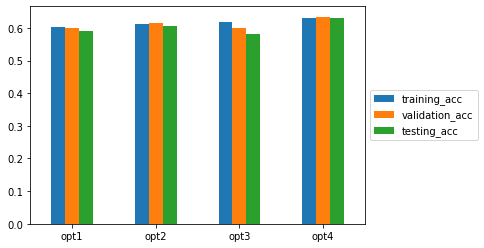

In [96]:
result[['training_acc', 'validation_acc', 'testing_acc']].plot.bar(rot=0).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

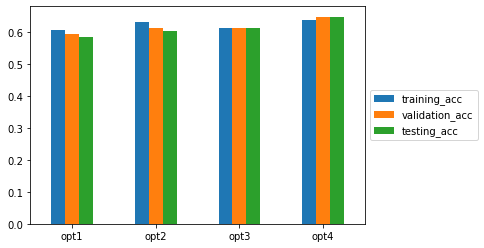

In [103]:
result[['training_acc', 'validation_acc', 'testing_acc']].plot.bar(rot=0).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))